# Segmentation Performance
Evaluation of membrane detection using watershed/variation of information (VI) and pixel-wise membrane error. Variation of Information is calculated using [partition_comparison](https://github.com/thouis/partition-comparison) and split VI is calculated using [gala](https://github.com/janelia-flyem/gala).

In [1]:
%matplotlib inline
import mahotas as mh
import cPickle
from gala import evaluate as ev
import numpy as np
import partition_comparison
import matplotlib.pyplot as plt
import cv2

In [2]:
def disk(radius):
    y, x = np.ogrid[-radius:radius+1, -radius:radius+1]
    return x**2 + y**2 <= radius**2


def watershed(probs, radius):
    sel = disk(radius)
    minima = mh.regmin(probs, Bc=sel)
    markers, nr_markers = mh.label(minima)
    return mh.cwatershed(probs, markers)

def partition_VI(putative, gold):
    mask = gold != 0
    VI_res = partition_comparison.variation_of_information(gold[mask], putative[mask].astype(gold.dtype))
    return VI_res

def evaluate_VI(pred,ground_truth,radii):

    if radii.size >1:
        VI = np.zeros((radii.size,3))
        r = 0
        for radius in radii:
            # VI_metric -> undersegmentation error,oversegmentation error,VI

            segmentation = watershed(pred,radius)
            VI_split =  ev.split_vi(segmentation, ground_truth)
            VI[r,0] += VI_split[0]
            VI[r,1] += VI_split[1]

            VI_partition = partition_VI(segmentation, ground_truth)    
            VI[r,2] += VI_partition   

            r += 1
    else:
        try:
            segmentation = watershed(pred,radii[0])
            VI = partition_VI(segmentation, ground_truth) 
        except:
            segmentation = watershed(pred,radii)
            VI = partition_VI(segmentation, ground_truth)
    
    return VI

def remove_synapse(img, threshold = 399):  
    for m in xrange(img.shape[0]):
        for n in xrange(img.shape[1]):
            if img[m,n] > threshold:
                img[m,n] = 0
    return img

def find_min(VI):
    # Find minimum VI value
    VI_min_pos = np.argmin(VI[:,2])
    return VI[VI_min_pos], VI_min_pos
    

### Calculate VI/Error
VI truth is the estimated VI for the membrane edges that are used as ground truth and represent the loss going from segmentation to edges and back. 

In [3]:
address1          = "../results/48x48_av/"
pred_48x48         = np.load(address1 + "/results/output.npy")
y1                = np.load(address1 + "/results/y.npy")
pred_window_size  = np.load(address1 + "/results/pred_window_size.npy")
gap1 = (pred_window_size[0]-pred_window_size[1])/2

address2          = "../results/tvr05/"
pred_05           = np.load(address2 + "/results/output.npy")
y2                = np.load(address2 + "/results/y.npy")
pred_window_size  = np.load(address2 + "/results/pred_window_size.npy")
gap2 = (pred_window_size[0]-pred_window_size[1])/2

address3          = "../results/tvr1/"
pred_1             = np.load(address3 + "/results/output.npy")
y2                = np.load(address3 + "/results/y.npy")
pred_window_size  = np.load(address3 + "/results/pred_window_size.npy")
gap2 = (pred_window_size[0]-pred_window_size[1])/2

# Load in test-addresses
f = file(address2 + "/pre_processed/" + "test_adress.dat", 'rb')
test_address = cPickle.load(f)
f.close()

print pred_48x48.shape
print pred_05.shape
print pred_1.shape


(5, 1, 1008, 1008)
(5, 1, 1008, 1008)
(5, 1, 1008, 1008)


In [4]:
radii = np.linspace(7, 85, 15)
VI_48x48 = np.zeros((radii.size,3))
VI_05 = np.zeros((radii.size,3))
VI_1 = np.zeros((radii.size,3))

n = 0
for address_img in test_address:
    ground_truth = mh.imread("../" + address_img)
    ground_truth = ground_truth[gap2:-gap2,gap2:-gap2]
    ground_truth = ground_truth.astype(np.uint16)
    ground_truth = remove_synapse(ground_truth)
    VI_48x48     += evaluate_VI( pred_48x48[n,0],ground_truth,radii)
    
    ground_truth = mh.imread("../" + address_img)
    ground_truth = ground_truth[gap1:-gap1,gap1:-gap1]
    ground_truth = ground_truth.astype(np.uint16)   
    VI_05       += evaluate_VI(pred_05[n,0],ground_truth,radii)
    
    ground_truth = mh.imread("../" + address_img)
    ground_truth = ground_truth[gap1:-gap1,gap1:-gap1]
    ground_truth = ground_truth.astype(np.uint16)   
    VI_1       += evaluate_VI(pred_1[n,0],ground_truth,radii)
    
    n += 1
    if n == 5:
        break
    
# Average VI
VI_48x48       /= float(n) 
VI_05          /= float(n) 
VI_1           /= float(n) 

print "Finshed VI/watershed"

# Calculate min VI
VI_min_48x48,min_index = find_min(VI_48x48)
VI_min_05,min_index = find_min(VI_05)
VI_min_1,min_index = find_min(VI_1)

# Calculate pixel erro
pixel_error_48x48 = np.mean(np.abs(pred_48x48-y1))
pixel_error_05 = np.mean(np.abs(pred_05-y2))
pixel_error_1 = np.mean(np.abs(pred_1-y2))

# Estimate Ideal VI
#radii_min = np.array([radii[min_index]],dtype=np.int32)

#VI_truth = evaluate_VI(y2[-1],ground_truth,radii_min)
#print "Estimated VI Truth:", VI_truth
    

Finshed VI/watershed


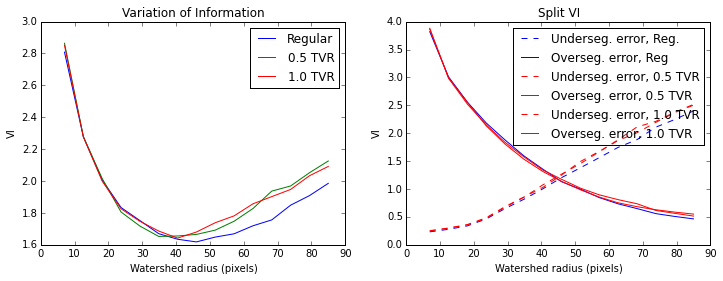

In [12]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("Variation of Information")
plt.xlabel("Watershed radius (pixels)")
plt.ylabel("VI")
plt.plot(radii,VI_48x48[:,2],label="Regular")
plt.plot(radii,VI_05[:,2],label="0.5 TVR")
plt.plot(radii,VI_1[:,2],label="1.0 TVR")
plt.legend(loc="best")

plt.subplot(1,2,2)
plt.title("Split VI")
plt.plot(radii,VI_48x48[:,0],label = "Underseg. error, Reg.",linestyle="--",color="blue")
plt.plot(radii,VI_48x48[:,1],label = "Overseg. error, Reg",color="blue")
plt.plot(radii,VI_05[:,0],label = "Underseg. error, 0.5 TVR",linestyle="--",color="red")
plt.plot(radii,VI_05[:,1],label = "Overseg. error, 0.5 TVR",color="red")
plt.plot(radii,VI_1[:,0],label = "Underseg. error, 1.0 TVR",linestyle="--",color="red")
plt.plot(radii,VI_1[:,1],label = "Overseg. error, 1.0 TVR",color="red")
plt.legend(loc="best")
plt.xlabel("Watershed radius (pixels)")
plt.ylabel("VI")

plt.savefig("comparison_tvr_VI")

### Best Segmentation Performance, regular

In [6]:
print "Variation of Information (VI):",VI_min_48x48[2]
print "VI, undersegmentation error:", VI_min_48x48[0]
print "VI, oversegmentation error:", VI_min_48x48[1]
print "Pixel-wise error:", pixel_error_48x48

Variation of Information (VI): 1.61808602278
VI, undersegmentation error: 1.20428769985
VI, oversegmentation error: 1.13011698096
Pixel-wise error: 0.20998580791


### Best Segmentation Performance, 0.5 TVR

In [7]:
print "Variation of Information (VI):",VI_min_05[2]
print "VI, undersegmentation error:", VI_min_05[0]
print "VI, oversegmentation error:", VI_min_05[1]
print "Pixel-wise error:", pixel_error_05

Variation of Information (VI): 1.65245044105
VI, undersegmentation error: 0.850667804426
VI, oversegmentation error: 1.53331425219
Pixel-wise error: 0.201506958719


### Best Segmentation Performance, 1.0 TVR

In [8]:
print "Variation of Information (VI):",VI_min_1[2]
print "VI, undersegmentation error:", VI_min_1[0]
print "VI, oversegmentation error:", VI_min_1[1]
print "Pixel-wise error:", pixel_error_1

Variation of Information (VI): 1.64206886146
VI, undersegmentation error: 1.02780052969
VI, oversegmentation error: 1.34120407354
Pixel-wise error: 0.202918323458


### Example pictures

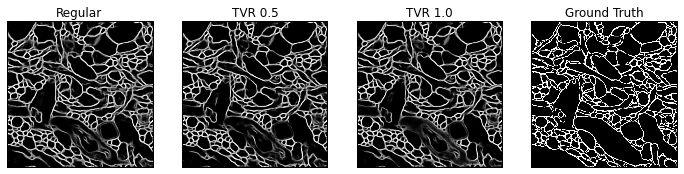

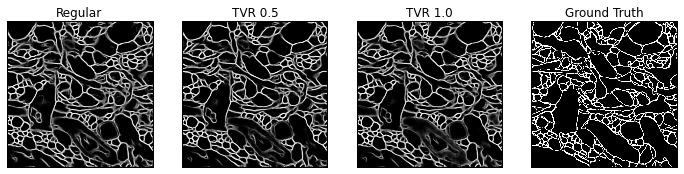

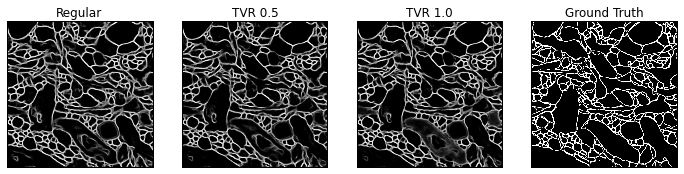

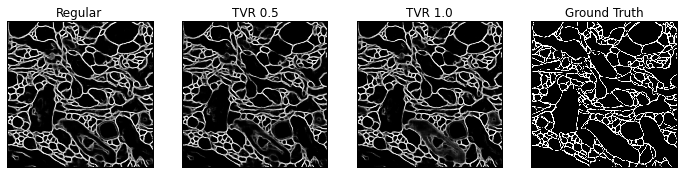

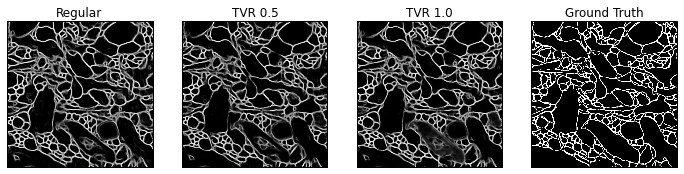

In [13]:
#pred_2x2 = np.load(address1 + "/results/output.npy")
#pred_48x48 = np.load(address2 + "/results/output.npy")
y = np.load(address1 + "/results/y.npy")

for n in xrange(y.shape[0]):

    plt.figure(figsize=(12,4))
    ax1 = plt.subplot(1,4,1)
    ax1.set_title("Regular")
    plt.imshow(pred_48x48[n,0],cmap=plt.cm.gray)
    ax1.grid(True)
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])

    ax2 = plt.subplot(1,4,2)
    ax2.set_title("TVR 0.5")
    plt.imshow(pred_05[n,0],cmap=plt.cm.gray)
    ax2.grid(True)
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    
    ax3 = plt.subplot(1,4,3)
    ax3.set_title("TVR 1.0")
    plt.imshow(pred_1[n,0],cmap=plt.cm.gray)
    ax3.grid(True)
    ax3.set_xticklabels([])
    ax3.set_yticklabels([])

    ax4 = plt.subplot(1,4,4)
    ax4.set_title("Ground Truth")
    plt.imshow(y[n,0],cmap=plt.cm.gray)
    ax4.grid(True)
    ax4.set_xticklabels([])
    ax4.set_yticklabels([])
    
    plt.savefig("comparison_tvr" + str(n))

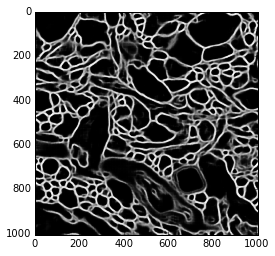

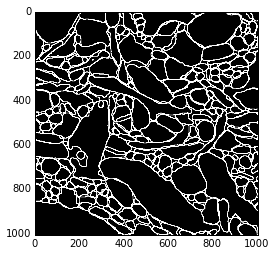

In [18]:
plt.imshow(pred_48x48[0,0],cmap=plt.cm.gray)
plt.figure()
plt.imshow(y[0,0],cmap=plt.cm.gray)